# Optimization Tutorial

Trey V. Wenger (c) July 2024

Here we demonstrate how to optimize the number of cloud components in a `bayes_spec` model.

In [1]:
# General imports
from IPython.display import SVG, display
    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None

# plot directory and extension
figdir = "figures"
ext = "svg"
if not os.path.isdir(figdir):
    os.mkdir(figdir)
    
# random state
rng = np.random.RandomState(seed=1234)

bayes_spec version: 1.0.0


## Model Definition and Simulated Data

Like in the basic tutorial, our model is a Gaussian line profile, except this time we use the example provided in `bayes_spec`. We generate synthetic data as in the basic tutorial, and the data key must be `"observation"` for this model.

Sampling: [amplitude_norm, fwhm_norm, observation_baseline_norm, observation_norm, velocity_norm]


Text(0, 0.5, 'Brightness Temperature (K)')

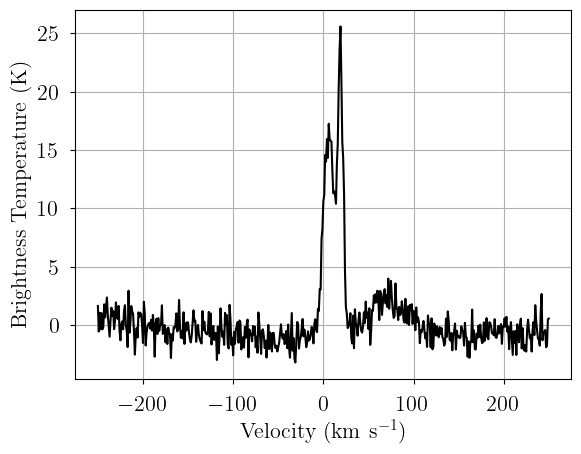

In [2]:
from bayes_spec import SpecData
from bayes_spec.models import GaussLine

# Generate dummy data format for simulation
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s
brightness_data = np.random.randn(len(velocity_axis)) # K
noise = 1.0 # K

observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Initialize and define the model
model = GaussLine(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.define(
    prior_amplitude=10.0, # K
    prior_fwhm=25.0, # km/s
    prior_velocity=[0.0, 50.0], # km/s
)

# Draw one posterior predictive sample
simulated = model.prior_predictive_check(
    samples=1,
)
sim_brightness = simulated.prior_predictive["observation"].sel(chain=0, draw=0)

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [3]:
# Pack simulated data into SpecData
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    GaussLine,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=3,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.define(
    prior_amplitude=10.0, # K
    prior_fwhm=25.0, # km/s
    prior_velocity=[0.0, 50.0], # km/s
)

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [6]:
fit_kwargs = {
    "learning_rate": 1e-3,
    "abs_tolerance": 0.01,
    "rel_tolerance": 0.01,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 7.086e+03
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 18500
Interrupted at 18,499 [3%]: Average Loss = 2,575.8


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 2.435e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 33400
Interrupted at 33,399 [6%]: Average Loss = 2,114.7


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.701e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 36000
Interrupted at 35,999 [7%]: Average Loss = 2,437.2


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.724e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 35500
Interrupted at 35,499 [7%]: Average Loss = 3,006.2


GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = 1.751e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 42400
Interrupted at 42,399 [8%]: Average Loss = 3,200.8


GMM converged to unique solution
n_cloud = 5 solution = 0 BIC = 1.778e+03

Sampling best model (n_cloud = 2)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 33400
Interrupted at 33,399 [6%]: Average Loss = 2,114.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, amplitude_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
display(az.summary(opt.best_model.trace.solution_0))

Best model has n_clouds = 2


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],16.991,0.391,16.309,17.764,0.006,0.004,3901.0,3151.0,1.0
amplitude[1],22.580,0.590,21.549,23.731,0.010,0.007,3762.0,3413.0,1.0
amplitude_norm[0],1.699,0.039,1.631,1.776,0.001,0.000,3901.0,3151.0,1.0
amplitude_norm[1],2.258,0.059,2.155,2.373,0.001,0.001,3762.0,3413.0,1.0
fwhm[0],13.469,0.488,12.568,14.382,0.009,0.006,3011.0,3005.0,1.0
fwhm[1],6.815,0.235,6.378,7.256,0.004,0.003,3213.0,3042.0,1.0
fwhm_norm[0],0.539,0.020,0.503,0.575,0.000,0.000,3011.0,3005.0,1.0
fwhm_norm[1],0.273,0.009,0.255,0.290,0.000,0.000,3213.0,3042.0,1.0
line_area[0],243.493,7.805,228.782,257.859,0.128,0.090,3712.0,3299.0,1.0
line_area[1],163.775,6.147,151.947,175.005,0.110,0.078,3151.0,3016.0,1.0


Notice that the "best" model is not what we expected (`n_clouds=3`). This is because VI has a hard time with this model. Alternatively, with `approx=False`, the optimization algorithm samples each model with MCMC and determines which is the first model with a BIC within `bic_threshold` of the minimum across all models. This is more accurate, but slower. Be careful not to set `max_n_clouds` too high!

In [8]:
opt.optimize(sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 7.086e+03
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 18500
Interrupted at 18,499 [3%]: Average Loss = 2,575.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, amplitude_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


Only 3 chains appear converged.
GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 2.434e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 33400
Interrupted at 33,399 [6%]: Average Loss = 2,114.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, amplitude_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.700e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 36000
Interrupted at 35,999 [7%]: Average Loss = 2,437.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, amplitude_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


Only 3 chains appear converged.
GMM converged to unique solution
Chain label order mismatch in solution 0
Chain 0 order: [0 1 2]
Chain 1 order: [2 0 1]
Chain 3 order: [1 0 2]
Adopting (first) most common order: [0 1 2]
n_cloud = 3 solution = 0 BIC = 1.512e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 35500
Interrupted at 35,499 [7%]: Average Loss = 3,006.2
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, amplitude_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


Only 3 chains appear converged.
There were 268 divergences in converged chains.
GMM found 2 unique solutions
Solution 0: chains [0]
Solution 1: chains [2]
n_cloud = 4 solution = 0 BIC = 1.551e+03
n_cloud = 4 solution = 1 BIC = 1.589e+03

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 42400
Interrupted at 42,399 [8%]: Average Loss = 3,200.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, amplitude_norm, fwhm_norm, velocity_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 155 seconds.


Only 3 chains appear converged.
There were 89 divergences in converged chains.
No solution found!
GMM found 0 unique solutions



Notice that models with more complexity than is present in the data (i.e., `n_clouds` > the true number of clouds) tend to have more divergences and difficulty converging.

In [9]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
display(az.summary(opt.best_model.trace.solution_0))

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],17.652,0.396,16.889,18.364,0.007,0.005,3396.0,2440.0,1.0
amplitude[1],3.203,0.226,2.786,3.639,0.004,0.003,3049.0,2068.0,1.0
amplitude[2],22.819,0.601,21.708,24.009,0.011,0.008,2841.0,2041.0,1.0
amplitude_norm[0],1.765,0.040,1.689,1.836,0.001,0.000,3396.0,2440.0,1.0
amplitude_norm[1],0.320,0.023,0.279,0.364,0.000,0.000,3049.0,2068.0,1.0
amplitude_norm[2],2.282,0.060,2.171,2.401,0.001,0.001,2841.0,2041.0,1.0
fwhm[0],14.133,0.527,13.187,15.153,0.011,0.008,2181.0,1858.0,1.0
fwhm[1],53.557,5.317,43.320,63.390,0.110,0.078,2348.0,2275.0,1.0
fwhm[2],6.886,0.243,6.451,7.356,0.005,0.003,2810.0,2139.0,1.0
fwhm_norm[0],0.565,0.021,0.527,0.606,0.000,0.000,2181.0,1858.0,1.0


With posteriors sampled with MCMC, we can also use leave-one-out cross-validation to perform model comparison.

In [10]:
# Populate models with likelihood samples
for model in opt.models.values():
    with model.model:
        pm.compute_log_likelihood(model.trace)

Output()

Output()

Output()

Output()

Output()

In [11]:
# leave-one-out cross validation
loo = az.compare({n_gauss: model.trace for n_gauss, model in opt.models.items()})
display(loo)

/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/twenger/miniconda3/envs/bayes_spec-dev/lib/python3.12/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/twenger/minico

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
3,0,-712.589477,15.529288,0.000000,1.000000e+00,15.881822,0.000000,False,log
5,1,-713.652610,18.131884,1.063133,0.000000e+00,15.889277,0.851807,True,log
4,2,-713.730792,17.191974,1.141316,5.239698e-13,15.986359,1.216035,True,log
2,3,-818.280329,14.351797,105.690852,0.000000e+00,23.597522,17.302735,False,log
1,4,-1221.726281,58.329650,509.136804,0.000000e+00,114.145911,111.562240,True,log


The model with the largest `elpd_loo` is preferred.